# Loan Approval Prediction

This project focuses on building a machine learning model to predict loan approval based on applicant details and financial attributes.  
The dataset includes variables such as income, loan amount, CIBIL score, assets, education, and employment status.  

**Objective:**  
To develop a classification model that can predict whether a loan application will be *Approved* or *Rejected*. 

## Step 1: Importing necessary libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

## Step 2: Importing the Dataset

We load the dataset which contains loan application records.  
The features include both categorical (e.g., Education, Self_Employed) and numerical variables (e.g., Income, CIBIL Score, Loan Amount).  
The target variable is **Loan Status** with two classes: *Approved* and *Rejected*.

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Elevvo/loan_approval_dataset.csv')
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [25]:
df.shape

(4269, 13)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [22]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())

['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


In [26]:
print(df['loan_status'].value_counts())
print(f"Approval rate: {(df['loan_status'] == 'Approved').mean():.2%}")

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64
Approval rate: 0.00%


In [17]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "There are no missing values")

There are no missing values


## Step 3: Exploratory Data Analysis
In this section, we perform data exploration to understand the structure, distribution, and relationships among variables.  
Key steps include:  
- Checking for missing values  
- Visualizing distributions of numerical features  
- Analyzing categorical features  
- Observing class imbalance in target variable

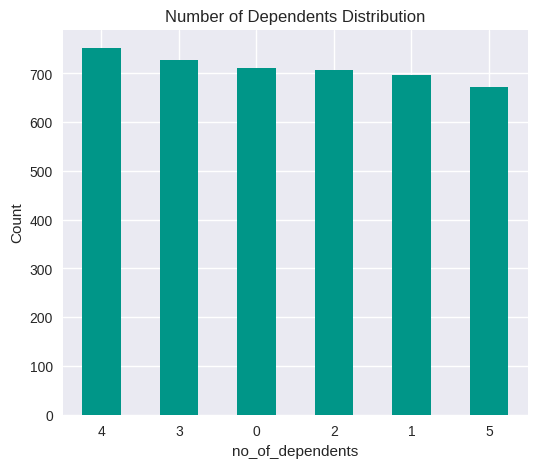

In [66]:
plt.figure(figsize=(6,5))
df['no_of_dependents'].value_counts().plot(
    kind='bar', color='#009688')
plt.title('Number of Dependents Distribution')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

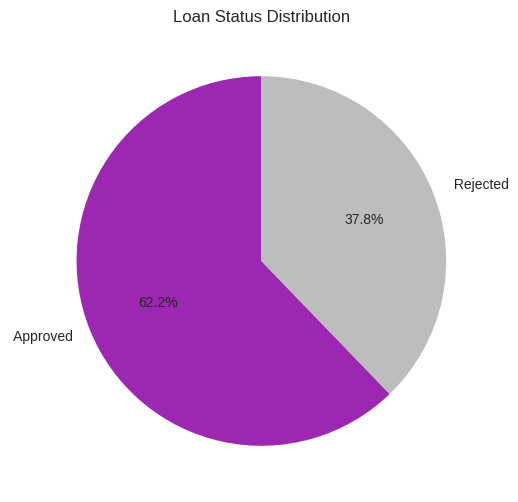

In [46]:
plt.figure(figsize=(6,6))
colors = ['#9C27B0', '#BDBDBD']
plt.pie(df['loan_status'].value_counts().values,
        labels=df['loan_status'].value_counts().index,
        autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Loan Status Distribution')
plt.show()

<Figure size 800x600 with 0 Axes>

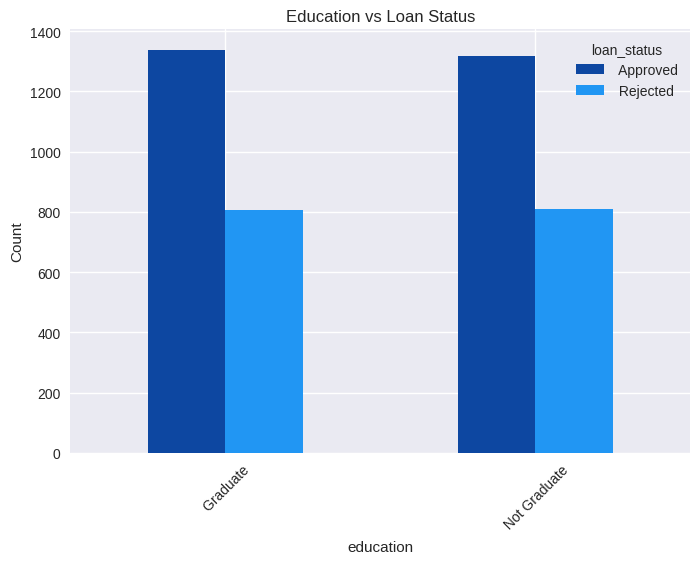

In [32]:
plt.figure(figsize=(8,6))
pd.crosstab(df['education'], df['loan_status']).plot(
    kind='bar', color=['#0D47A1', '#2196F3'])  # green & red
plt.title('Education vs Loan Status')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

<Figure size 600x500 with 0 Axes>

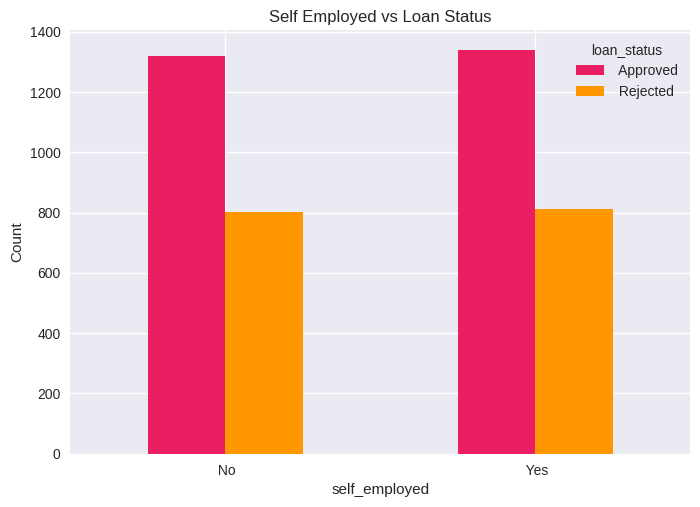

In [37]:
plt.figure(figsize=(6,5))
pd.crosstab(df['self_employed'], df['loan_status']).plot(
    kind='bar', color=['#E91E63', '#FF9800'])  # blue & orange
plt.title('Self Employed vs Loan Status')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()


In [44]:
df.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


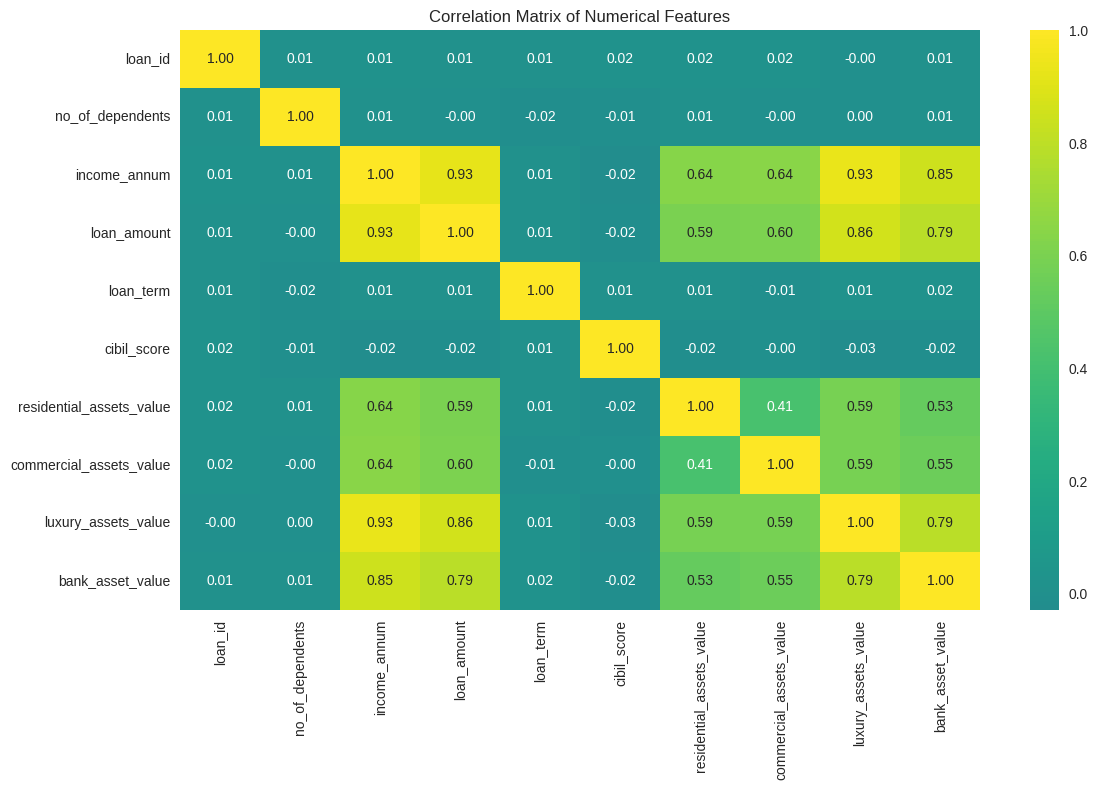

In [55]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## Step 4: Data Preprocessing

Before model training, preprocessing is required:  
- Encoding categorical variables  
- Feature scaling (for models sensitive to scale)  
- Balancing the dataset using **SMOTE** to deal with class imbalance  


In [56]:
df_processed = df.copy()

# Create new features
df_processed['loan_to_income_ratio'] = df_processed['loan_amount'] / df_processed['income_annum']
df_processed['total_assets'] = (df_processed['residential_assets_value'] +
                               df_processed['commercial_assets_value'] +
                               df_processed['luxury_assets_value'] +
                               df_processed['bank_asset_value'])
df_processed['asset_to_loan_ratio'] = df_processed['total_assets'] / df_processed['loan_amount']


In [57]:
categorical_cols = ['education', 'self_employed']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

In [63]:
le_target = LabelEncoder()
df_processed['loan_status_encoded'] = le_target.fit_transform(df_processed['loan_status'])

# Select features for modeling
feature_columns = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
                  'cibil_score', 'residential_assets_value', 'commercial_assets_value',
                  'luxury_assets_value', 'bank_asset_value', 'education_encoded',
                  'self_employed_encoded', 'loan_to_income_ratio', 'total_assets',
                  'asset_to_loan_ratio']

X = df_processed[feature_columns]
y = df_processed['loan_status_encoded']
X.shape

(4269, 14)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 5: Model Training

We apply different machine learning classification models such as:  
- Logistic Regression  
- Decision Tree Classifier  
- Random Forest Classifier  

The models are trained on the preprocessed dataset and evaluated on test data.

### 1. Logistic Regression

In [83]:

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')
print("CV F1 Score Mean:", cv_scores.mean())


Accuracy: 0.8149882903981265
Precision: 0.8260869565217391
Recall: 0.6470588235294118
F1 Score: 0.7256944444444444
CV F1 Score Mean: 0.7160839668108675


### 2. Decision Tree

In [82]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

cv_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='f1')
print("CV F1 Score Mean:", cv_scores.mean())

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
CV F1 Score Mean: 0.9980627506841099


### 3. Random Forest

In [84]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
print("CV F1 Score Mean:", cv_scores.mean())

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
CV F1 Score Mean: 0.9972845492680686


In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

 BASELINE MODELS (Without SMOTE)


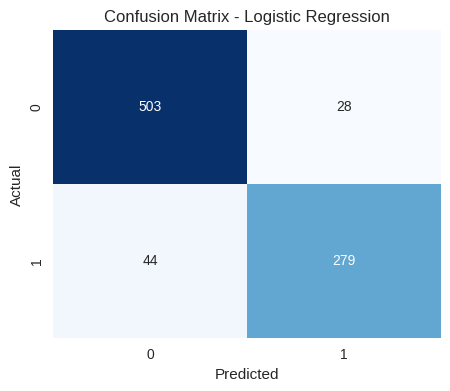

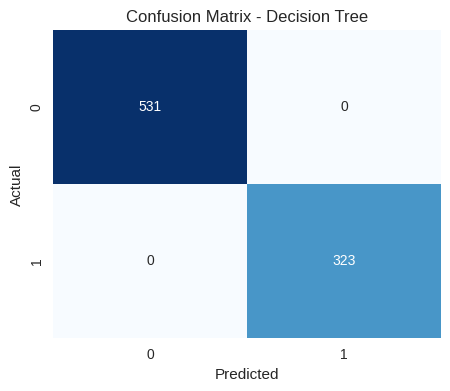

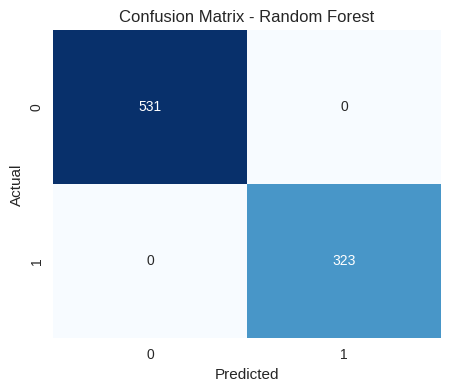

In [88]:
print(" BASELINE MODELS (Without SMOTE)")
results = {}

log_reg = LogisticRegression(max_iter=1000, random_state=42)
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

results['Logistic Regression'] = evaluate_model(log_reg, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
results['Decision Tree'] = evaluate_model(decision_tree, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")
results['Random Forest'] = evaluate_model(random_forest, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")



 MODELS WITH SMOTE


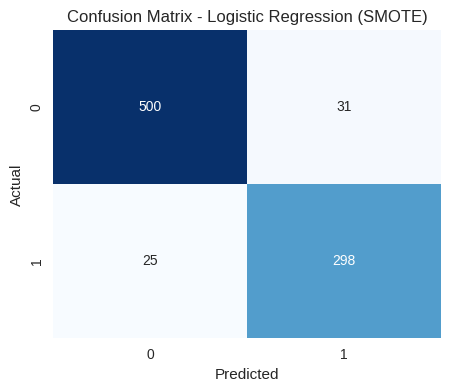

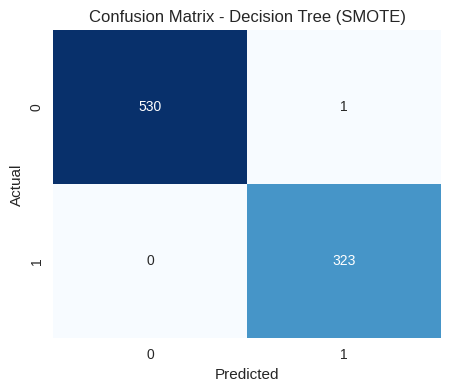

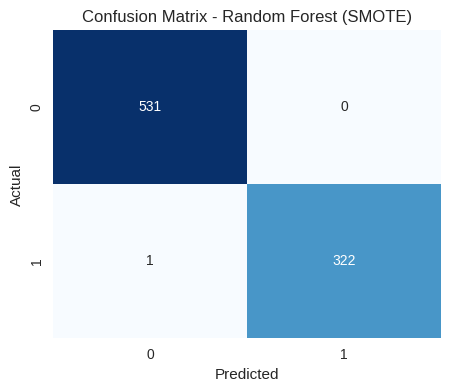

In [90]:
print("\n MODELS WITH SMOTE")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

results['Logistic Regression (SMOTE)'] = evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_smote, X_test_scaled, y_train_smote, y_test, "Logistic Regression (SMOTE)"
)

results['Decision Tree (SMOTE)'] = evaluate_model(
    DecisionTreeClassifier(random_state=42),
    X_train_smote, X_test_scaled, y_train_smote, y_test, "Decision Tree (SMOTE)"
)

results['Random Forest (SMOTE)'] = evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_smote, X_test_scaled, y_train_smote, y_test, "Random Forest (SMOTE)"
)

In [91]:
comparison_df = pd.DataFrame(results).T
print("\n Model Comparison:")
print(comparison_df)


 Model Comparison:
                             accuracy  precision    recall        f1
Logistic Regression          0.915691   0.915489  0.915691  0.915246
Decision Tree                1.000000   1.000000  1.000000  1.000000
Random Forest                1.000000   1.000000  1.000000  1.000000
Logistic Regression (SMOTE)  0.934426   0.934754  0.934426  0.934542
Decision Tree (SMOTE)        0.998829   0.998833  0.998829  0.998829
Random Forest (SMOTE)        0.998829   0.998831  0.998829  0.998829


# Conclusion and Key Takeaways

### Conclusion  
The loan approval prediction task demonstrates how machine learning can be applied in financial decision-making.  
By analyzing customer data such as income, CIBIL score, and assets, we are able to predict loan approval outcomes with high accuracy.  

### Key Takeaways  
- Data preprocessing (handling missing values, encoding, scaling) plays a crucial role in model performance.  
- Class imbalance can significantly affect prediction results; applying **SMOTE** improved fairness across classes.  
- Random Forest and Logistic Regression provided reliable performance compared to a single Decision Tree.  
- Evaluation using multiple metrics (accuracy, precision, recall, F1-score) gives a holistic view of model effectiveness.  
- The developed model can be integrated into a loan approval system to support decision-making and reduce manual effort.
